In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim



from bs4 import BeautifulSoup
from urllib.request import urlopen
import requests
from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans


!conda install -c conda-forge folium=0.5.0 --yes
import folium



print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    branca-0.4.1               |             py_0          26 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                       

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = urlopen(url).read().decode('utf-8')
soup = BeautifulSoup(page, 'html.parser')

wiki_table = soup.body.table.tbody

In [3]:
def get_cell(element):
    cells = element.find_all('td')
    row = []
    
    for cell in cells:
        if cell.a:            
            if (cell.a.text):
                row.append(cell.a.text)
                continue
        row.append(cell.string.strip())
        
    return row

In [4]:
def get_row():    
    data = []  
    
    for tr in wiki_table.find_all('tr'):
        row = get_cell(tr)
        if len(row) != 3:
            continue
        data.append(row)        
    
    return data

In [5]:
data = get_row()
columns = ['PostalCode', 'Borough', 'Neighbourhood']
ca = pd.DataFrame(data, columns=columns)
ca.head()

,PostalCode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [6]:
ca.shape

(180, 3)

In [7]:
ca1 = ca[ca.Borough != 'Not assigned']
ca1 = ca1.sort_values(by=['PostalCode','Borough'])

ca1.reset_index(inplace=True)
ca1.drop('index',axis=1,inplace=True)

ca1.head()

,PostalCode,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
ca2 = ca1.copy()
ca2 = ca2[ca1.Borough.str.contains("Toronto")]
ca2.head()

,PostalCode,Borough,Neighbourhood
37,M4E,East Toronto,The Beaches
41,M4K,East Toronto,"The Danforth West, Riverdale"
42,M4L,East Toronto,"India Bazaar, The Beaches West"
43,M4M,East Toronto,Studio District
44,M4N,Central Toronto,Lawrence Park


In [9]:
ca_postcodes = ca2['PostalCode']
ca_postcodes.drop_duplicates(inplace=True)
can = pd.DataFrame(ca_postcodes)
can['Borough'] = '';
can['Neighbourhood'] = '';


can.reset_index(inplace=True)
can.drop('index', axis=1, inplace=True)
ca2.reset_index(inplace=True)
ca2.drop('index', axis=1, inplace=True)

for i in can.index:
    for j in ca2.index:
        if can.iloc[i, 0] == ca2.iloc[j, 0]:
            can.iloc[i, 1] = ca2.iloc[j, 1]
            can.iloc[i, 2] = ca2.iloc[i, 2] + ',' + ca2.iloc[j, 2]
            
for i in can.index:
    s = can.iloc[i, 2]
    if s[0] == ',':
        s =s [1:]
    can.iloc[i,2 ] = s
    
    

In [10]:
can.head()

,PostalCode,Borough,Neighbourhood
0,M4E,East Toronto,"The Beaches,The Beaches"
1,M4K,East Toronto,"The Danforth West, Riverdale,The Danforth West..."
2,M4L,East Toronto,"India Bazaar, The Beaches West,India Bazaar, T..."
3,M4M,East Toronto,"Studio District,Studio District"
4,M4N,Central Toronto,"Lawrence Park,Lawrence Park"


In [11]:
geo_url= "http://cocl.us/Geospatial_data"
can_geo = pd.read_csv(geo_url)
can_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [12]:
can['Latitude'] = '0';
can['Longitude'] = '0';

In [13]:
for i in can.index:
    for j in can_geo.index:
        if can.iloc[i, 0] == can_geo.iloc[j, 0]:
            can.iloc[i, 3] = can_geo.iloc[j, 1]
            can.iloc[i, 4] = can_geo.iloc[j, 2]
            
can.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,"The Beaches,The Beaches",43.6764,-79.293
1,M4K,East Toronto,"The Danforth West, Riverdale,The Danforth West...",43.6796,-79.3522
2,M4L,East Toronto,"India Bazaar, The Beaches West,India Bazaar, T...",43.669,-79.3156
3,M4M,East Toronto,"Studio District,Studio District",43.6595,-79.3409
4,M4N,Central Toronto,"Lawrence Park,Lawrence Park",43.728,-79.3888


In [14]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(can['Borough'].unique()),
        can.shape[0]
    )
)

The dataframe has 4 boroughs and 39 neighborhoods.


In [15]:
toronto_map = folium.Map(location=[43.65, -79.4], zoom_start=12)

X = can['Latitude']
Y = can['Longitude']
Z = np.stack((X, Y), axis=1)

kmeans = KMeans(n_clusters=4, random_state=0).fit(Z)

clusters = kmeans.labels_
colors = ['red', 'green', 'blue', 'yellow']
can['Cluster'] = clusters

for latitude, longitude, borough, cluster in zip(can['Latitude'], can['Longitude'], can['Borough'], can['Cluster']):
    label = folium.Popup(borough, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(toronto_map)  

toronto_map

In [16]:
CLIENT_ID = '5AX1ZBPB0VZ2IYYJDDMJMSVQ0HTW2LRGXH3XU0MPCQMUSBV5' # your Foursquare ID
CLIENT_SECRET = 'DJ4Z2SUQSXBT0VSPGPZNQXY4XVEJ0XDBM3DRWU2GZH5TD13O' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5AX1ZBPB0VZ2IYYJDDMJMSVQ0HTW2LRGXH3XU0MPCQMUSBV5
CLIENT_SECRET:DJ4Z2SUQSXBT0VSPGPZNQXY4XVEJ0XDBM3DRWU2GZH5TD13O


In [17]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.6534817 -79.3839347


In [18]:

can.loc[15, 'Neighbourhood']

'St. James Town,St. James Town'

In [19]:
neighborhood_latitude = can.loc[15, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = can.loc[15, 'Longitude'] # neighborhood longitude value

neighborhood_name = can.loc[15, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of St. James Town,St. James Town are 43.6514939, -79.3754179.


In [20]:
LIMIT = 1000 # limit of number of venues returned by Foursquare API
radius = 5000 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

In [21]:
results = requests.get(url).json()

In [22]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [23]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Fahrenheit Coffee,Coffee Shop,43.652384,-79.372719
1,Hogtown Smoke,Food Truck,43.649287,-79.374689
2,GEORGE Restaurant,Restaurant,43.653346,-79.374445
3,Elgin And Winter Garden Theatres,Theater,43.653394,-79.378507
4,Mystic Muffin,Middle Eastern Restaurant,43.652484,-79.372655


In [24]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [25]:

toronto_venues = getNearbyVenues(names=can['Neighbourhood'],
                                   latitudes=can['Latitude'],
                                   longitudes=can['Longitude'],
                                  radius=radius)

The Beaches,The Beaches
The Danforth West, Riverdale,The Danforth West, Riverdale
India Bazaar, The Beaches West,India Bazaar, The Beaches West
Studio District,Studio District
Lawrence Park,Lawrence Park
Davisville North,Davisville North
North Toronto West,  Lawrence Park,North Toronto West,  Lawrence Park
Davisville,Davisville
Moore Park, Summerhill East,Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park,Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale,Rosedale
St. James Town, Cabbagetown,St. James Town, Cabbagetown
Church and Wellesley,Church and Wellesley
Regent Park, Harbourfront,Regent Park, Harbourfront
Garden District, Ryerson,Garden District, Ryerson
St. James Town,St. James Town
Berczy Park,Berczy Park
Central Bay Street,Central Bay Street
Richmond, Adelaide, King,Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands,Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centr

In [26]:
print(toronto_venues.shape)
toronto_venues.head()

(3900, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"The Beaches,The Beaches",43.676357,-79.293031,The Fox Theatre,43.672801,-79.287272,Indie Movie Theater
1,"The Beaches,The Beaches",43.676357,-79.293031,The Beech Tree,43.680493,-79.288846,Gastropub
2,"The Beaches,The Beaches",43.676357,-79.293031,Ed's Real Scoop,43.672630,-79.287993,Ice Cream Shop
3,"The Beaches,The Beaches",43.676357,-79.293031,Kew Gardens,43.669038,-79.298538,Park
4,"The Beaches,The Beaches",43.676357,-79.293031,Beaches Bake Shop,43.680363,-79.289692,Bakery


In [27]:
toronto_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Berczy Park,Berczy Park",100,100,100,100,100,100
"Brockton, Parkdale Village, Exhibition Place,Brockton, Parkdale Village, Exhibition Place",100,100,100,100,100,100
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto,Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,100
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport,CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",100,100,100,100,100,100
"Central Bay Street,Central Bay Street",100,100,100,100,100,100


In [28]:

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronro_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Afghan Restaurant,American Restaurant,Amphitheater,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Caribbean Restaurant,Castle,Chinese Restaurant,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Nail Salon,Neighborhood,New American Restaurant,Nightclub,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool Hall,Pub,Ramen Restaurant,Record Shop,Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"The Beaches,The Beaches",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"The Beaches,The Beaches",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"The Beaches,The Beaches",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"The Beaches,The Beaches",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"The Beaches,The Beaches",0,0,0,0,0,0,0,0,0,0,0,

In [29]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Amphitheater,Aquarium,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Bike Shop,Bookstore,Botanical Garden,Boutique,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Butcher,Café,Caribbean Restaurant,Castle,Chinese Restaurant,Circus,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Flea Market,Flower Shop,Food & Drink Shop,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gastropub,General Entertainment,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hostel,Hotel,Hungarian Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Liquor Store,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Museum,Music School,Music Store,Nail Salon,New American Restaurant,Nightclub,Organic Grocery,Other Great Outdoors,Pakistani Restaurant,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pool Hall,Pub,Ramen Restaurant,Record Shop,Restaurant,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Street Art,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Yoga Studio
0,"Berczy Park,Berczy Park",0,1,0,1,1,0,1,1,0,0,2,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,3,0,0,0,1,1,0,11,1,0,1,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,1,1,0,0,0,0,2,3,0,0,0,0,0,1,0,0,0,0,2,0,0,3,0,1,0,0,0,3,2,0,0,0,1,0,1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,7,1,0,0,2,0,3,0,0,0,1,2,0,3,0,2,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,2,1,0,0,0,1
1,"Brockton, Parkdale Village, Exhibition Place,B...",0,0,0,1,1,1,0,0,0,0,6,3,1,0,1,4,1,0,1,0,0,0,3,1,0,0,0,1,5,1,0,0,0,0,1,1,0,0,1,1,1,0,1,0,1,1,0,2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,1,0,1,0,1,0,3,1,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,1,0,0,11,1,0,0,3,0,0,0,1,0,1,4,0,2,1,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,1,0,0
2,"Business reply mail Processing Centre, South C...",0,1,0,0,0,0,2,1,1,0,2,2,0,0,6,1,0,0,1,0,1,1,6,0,0,0,1,1,7,1,0,0,1,0,1,5,1,0,1,0,0,0,0,0,0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,2,1,1,0,0,0,0,1,0,0,1,1,5,1,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,10,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0,1,0,1,1,1,0,0,0,0,5,0,1,1,1,1,1,0,1,0,0,0,2,0,0,0,0,1,5,1,0,0,0,1,1,4,0,1,1,1,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,4,0,1,0,0,0,3,2,0,0,0,1,0,1,1,1,1,1,1,1,0,0,0,0,0,1,0,0,9,1,0,0,2,0,1,0,0,0,1,3,0,2,1,3,0,0,0,1,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,2,1,0,0,0,0
4,"Central Bay Street,Central Bay Street",0,1,0,1,1,1,0,0,0,0,2,1,0,1,0,2,0,0,2,1,0,0,1,0,0,0,0,1,5,1,0,0,0,1,0,7,1,1,1,0,0,1,0,0,1,2,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,1,0,0,0,0,1,4

<BarContainer object of 164 artists>

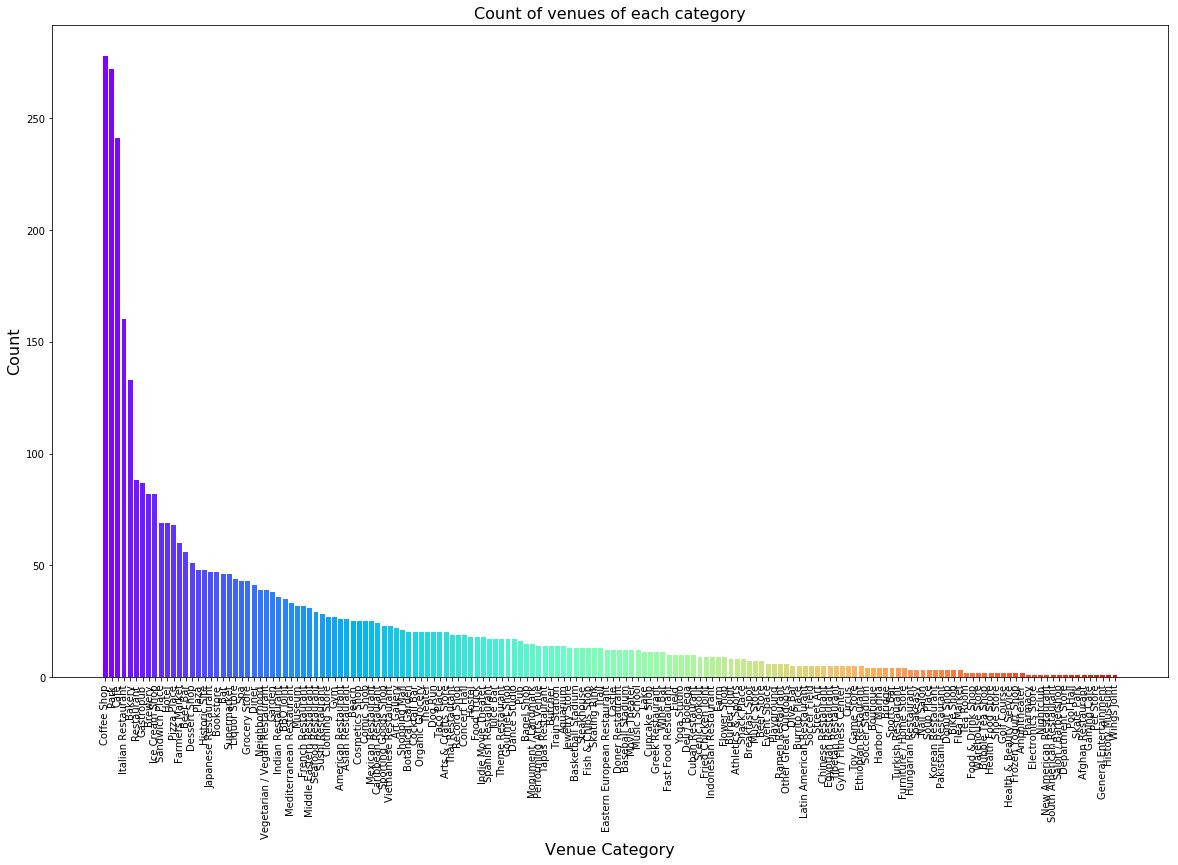

In [30]:
venue_distribution = toronto_venues['Venue Category'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue Category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

In [31]:
toronto_grouped[['Neighborhood','Vegetarian / Vegan Restaurant']]

,Neighborhood,Vegetarian / Vegan Restaurant
0,"Berczy Park,Berczy Park",2
1,"Brockton, Parkdale Village, Exhibition Place,B...",1
2,"Business reply mail Processing Centre, South C...",1
3,"CN Tower, King and Spadina, Railway Lands, Har...",2
4,"Central Bay Street,Central Bay Street",2
5,"Christie,Christie",1
6,"Church and Wellesley,Church and Wellesley",2
7,"Commerce Court, Victoria Hotel,Commerce Court,...",2
8,"Davisville North,Davisville North",0
9,"Davisville,Davisville",0


In [32]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [33]:
X=toronto_grouped.drop(['Neighborhood','Vegetarian / Vegan Restaurant'],axis=1)
y=toronto_grouped['Vegetarian / Vegan Restaurant']

In [34]:
svr_rbf = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

In [35]:
svr_rbf.fit(X,y)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1.0, 10.0, 100.0, 1000.0], 'gamma': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
svr_rbf.cv_results_

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/envs/Python36/

{'mean_fit_time': array([0.00171347, 0.00156069, 0.00149446, 0.00162368, 0.00157723,
        0.0015296 , 0.00157671, 0.00154152, 0.00147595, 0.00149317,
        0.00155387, 0.00156713, 0.00156841, 0.00154028, 0.00157747,
        0.00155144, 0.00150952, 0.00153289, 0.00147147, 0.00153542]),
 'std_fit_time': array([3.04759584e-04, 3.38080572e-05, 3.90335414e-05, 7.08918151e-05,
        5.17401496e-05, 4.28791954e-05, 5.26660975e-05, 7.40202109e-05,
        6.54474590e-05, 5.51458411e-05, 6.44916924e-05, 3.30984759e-05,
        4.26732227e-05, 4.91467618e-05, 1.02388342e-04, 4.03561460e-05,
        3.88271372e-05, 2.56477228e-05, 1.94607988e-05, 3.68826684e-05]),
 'mean_score_time': array([0.00089698, 0.00080404, 0.00081253, 0.01877952, 0.00080943,
        0.00084529, 0.00081367, 0.00083098, 0.00078468, 0.00079565,
        0.00081773, 0.00079031, 0.00081668, 0.00079575, 0.00084343,
        0.00078874, 0.00083165, 0.00078449, 0.00080328, 0.00082588]),
 'std_score_time': array([9.90553192e-

In [37]:

regr=svr_rbf.best_estimator_ 
regr

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [38]:

regr.fit(X,y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

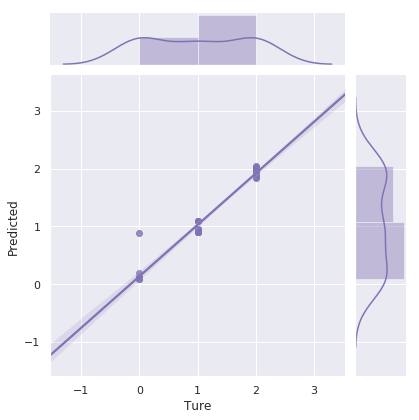

In [39]:
y_rbf=regr.predict(X)

data=pd.DataFrame([y,y_rbf], index=["Ture", "Predicted"])
data=data.T
import seaborn as sns
sns.set(style="darkgrid")

g = sns.jointplot("Ture", "Predicted", data=data, kind="reg",color="m")